In [1]:
import rasterio , os 
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
import pandas as pd
import numpy as np
import geopandas as gpd
from rasterio.plot import show
import matplotlib.pyplot as plt
import rasterio.plot as rplt
from rasterio.features import rasterize
from rasterstats import zonal_stats
import warnings
warnings.filterwarnings('ignore')

def enumerate_items(source):
    print("/n")
    for ele in enumerate(source): 
        print(ele)

def list_df_columns(df):
    field_list = list(df)
    enumerate_items(field_list)
    return field_list

def millions_formatter(x, pos):
    return f'{x / 1000000 :,.0f}'

def billions_formatter(x, pos):
    return f'{x / 1000000000 :,.0f}'

# For loading shapefiles into geopandas dataframe
def load_shapefile(shp):
    data = gpd.read_file(shp)
    return data

# For re-projecting input vector layer to raster projection 
def reproject_gpdf(input_gpdf, raster):
    proj = raster.crs.to_proj4()
    # print("Original gpdf projection: ", input_gpdf.crs)
    reproj = input_gpdf.to_crs(proj)
    # print("New gpdf projection (PROJ4): ", reproj.crs)
    return reproj

# For selecting which raster statistics to calculate
def list_statistics():
    # out_stats = ['min', 'max', 'mean', 'count', 
    #           'sum', 'std', 'median', 'majority', 
    #           'minority', 'unique', 'range'
    #           ]
    out_stats = ['sum']
    return out_stats

# For calculating zonal statistics
def calculate_zonal_stats(vector, raster, stats):
    # Run zonal statistics, store result in geopandas dataframe
    result = zonal_stats(vector, raster, stats=stats, geojson_out=True)
    geostats = gpd.GeoDataFrame.from_features(result)
    for c in stats:
        geostats[c] = np.round(geostats[c] , decimals= 2)
    return geostats

# For generating raster from zonal statistics result
def export_zonal_stats_raster(zdf, raster, stats, out_raster, no_data='y'):
    meta = raster.meta.copy()
    out_shape = raster.shape
    transform = raster.transform
    dtype = raster.dtypes[0]
    field_list = list_df_columns(stats)
    index = 0 #first statistic for now
    zone = zdf[field_list[index]]
    stats = list_statistics()
    shapes = ((geom,value) for geom, value in zip(zdf.geometry, zone))
    burned = rasterize(shapes=shapes, fill=0, out_shape=out_shape, transform=transform)
    # show(burned)
    meta.update(dtype=rasterio.float32, nodata=0)
    # Optional to set nodata values to min of stat
    if no_data == 'y':
        cutoff = min(zone.values)
        # print("Setting nodata cutoff to: ", cutoff)
        burned[burned < cutoff] = 0 
    with rasterio.open(out_raster, 'w', **meta) as out:
        out.write_band(1, burned)
    # print("Zonal Statistics Raster generated")

def visualize_popdynamics_figure(df_for_heatmap, country, city, subdir):
    # Create a mask for the NaN values
    mask = df_for_heatmap.isnull()
    # Create a heatmap using seaborn
    fig, ax = plt.subplots(figsize=(14,5))
    stats = list_statistics()
    for c in stats:
        if c=="sum":
            df_formatted =df_for_heatmap.applymap( lambda val: f'{val / 1000000:,.0f}M')
            fmt = ''
        else:
            fmt = '.0f'
        sns.heatmap(df_for_heatmap,  annot=df_formatted, cmap='YlGnBu', cbar=False, fmt=fmt,
                    square=True, annot_kws={'size': 10},
                    linewidths=1, linecolor='gray',
                    cbar_kws={'label': 'Value'}, ax=ax)

        ax.patch.set_edgecolor('black')  
        ax.patch.set_linewidth(1)  
        plt.title(f"Demographic Dynamics of {city}\n Projected Population in millions")
        plt.savefig(f"{output_dir}/{country}_{city}_{subdir}_{c}.jpeg" , dpi=300, bbox_inches='tight')
        plt.show()

def visualize_popdynamics_graph(df_for_graph, country, city, subdir):
    df_for_graph['Year'] = pd.to_datetime(
                            df_for_graph['Year'],
                            format='%Y'
                            )
    # plot data
    g = sns.lineplot(data=df_for_graph, x="Year", y="value", 
                     hue="Scenario", palette="flare"
                     )
    g.set(xlabel='Year', ylabel='Population (millions)')
    # g.axes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, p: f'{y/1000000:.0f}'))
    g.axes.yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))
    # Tell matplotlib to interpret the x-axis values as dates
    g.xaxis_date()
    g.get_figure().savefig(f"{output_dir}/{country}_{city}_{subdir}_graph.jpeg" , dpi=300, bbox_inches='tight')
    # fig.savefig(f'{DATADIR}CMIP6_annual_global_tas.png')

def visualize_gdp_figure(df_for_heatmap, country, city, subdir):
    # Create a mask for the NaN values
    mask = df_for_heatmap.isnull()
    # Create a heatmap using seaborn
    fig, ax = plt.subplots(figsize=(14,5))
    stats = list_statistics()
    for c in stats:
        if c=="sum":
            # df_formatted =df_for_heatmap.applymap( lambda val: f'{val / 1000000000:,.0f}B' )
            df_formatted =df_for_heatmap.applymap( lambda val: f'{val / 1000000000:,.0f}B' )
            fmt = ''
        else:
            fmt = '.0f'
        sns.heatmap(df_for_heatmap,  annot=df_formatted, cmap='YlGnBu', cbar=False, fmt=fmt,
                    square=True, annot_kws={'size': 10},
                    linewidths=1, linecolor='gray',
                    cbar_kws={'label': 'Value'}, ax=ax)

        ax.patch.set_edgecolor('black')  
        ax.patch.set_linewidth(1)  
        plt.title(f"Projected GDP of {city}\n in Billions USD")
        plt.savefig(f"{output_dir}/{country}_{city}_{subdir}_heatmap.jpeg" , dpi=300, bbox_inches='tight')
        plt.show()

def visualize_gdp_graph(df_for_graph, country, city, subdir):
    df_for_graph['Year'] = pd.to_datetime(
                            df_for_graph['Year'],
                            format='%Y'
                            )
    # plot data
    g = sns.lineplot(data=df_for_graph, x="Year", y="value", 
                     hue="Scenario", palette="flare"
                     )
    g.set(xlabel='Year', ylabel='GDP (Billions USD)')
    # g.axes.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, p: f'{y/1000000:.0f}'))
    g.axes.yaxis.set_major_formatter(ticker.FuncFormatter(billions_formatter))
    # Tell matplotlib to interpret the x-axis values as dates
    g.xaxis_date()
    g.get_figure().savefig(f"{output_dir}/{country}_{city}_{subdir}_graph.jpeg" , dpi=300, bbox_inches='tight')


In [2]:
base_dir= 'C:/Users/Aziz/Dropbox/CRP/FCS' # Project directory
output_dir= f'{base_dir}/output' # csv and figure output directory
data_dir= f'{base_dir}/data'  # Input data directory
shp = f'{data_dir}/test_cities/Test_City2.shp' # City shapefile
country = 'BGD'
city= 'Chittagong'
fsc_data_sections= ['popdynamics']
          
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

def export_popdynamics():
    for subdir in fsc_data_sections:
        combined_results = []
        extension = '.tif'
        for root, dirs_list, files_list in os.walk( os.path.join(data_dir, subdir)):
            for file_name in files_list:
                if os.path.splitext(file_name)[-1] == extension:
                    file_name_path = os.path.join(root, file_name)
                    file_name = os.path.splitext(file_name)[0]
                    # print(file_name,  file_name_path, subdir)
                    Year = file_name.split('_')[1]
                    ssp = file_name.split('_')[0]
                    # print(file_name,  file_name_path, Year, ssp , subdir)
                    rst = file_name_path # f'{data_dir}/popdynamics/wang/SPP1/SSP1_2020.tif'
                    out_rst = f'{output_dir}/{subdir}_{file_name}.tif'
                    raster = rasterio.open(rst)
                    vector = load_shapefile(shp)
                    p_vector = reproject_gpdf(vector, raster)
                    stats_to_get = list_statistics()
                    df = calculate_zonal_stats(p_vector, rst, stats_to_get)
                    df['Scenario'] = ssp
                    df['Year'] = Year
                    combined_results.append(df)

        # Append vertically and then pivot horizontally.
        df = gpd.GeoDataFrame( pd.concat( combined_results, ignore_index=True) )
        # Wide
        df_tranformed= df.pivot(index=['Scenario'], columns='Year', values='sum')
        # Long
        df_graph = df_tranformed.melt(ignore_index=False).reset_index()
        # export csv of wide
        df_tranformed.to_csv(f"{output_dir}/{country}_{city}_{subdir}.csv")
        #run the visualize function to export the heatmap
        visualize_popdynamics_figure(df_tranformed, country, city, subdir)
        # Visualize pop dynamics graph
        visualize_popdynamics_graph(df_graph, country, city, subdir)

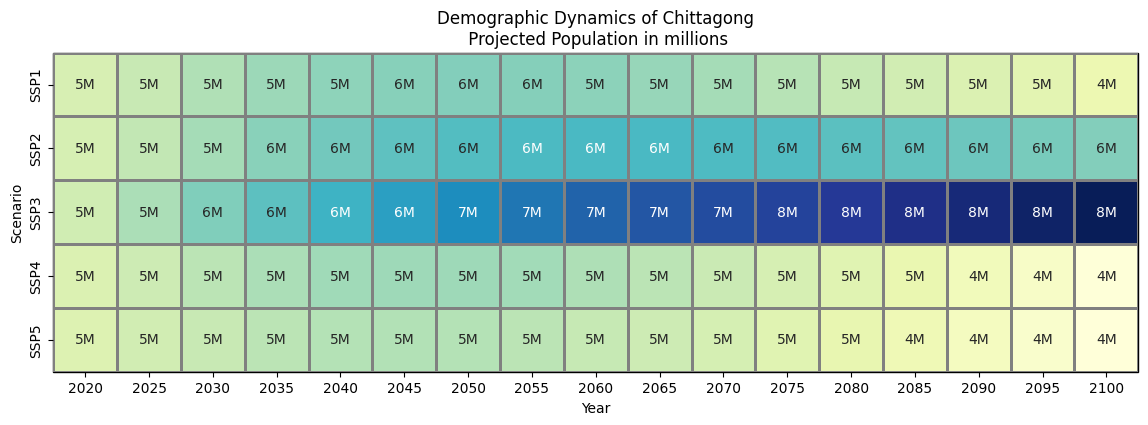

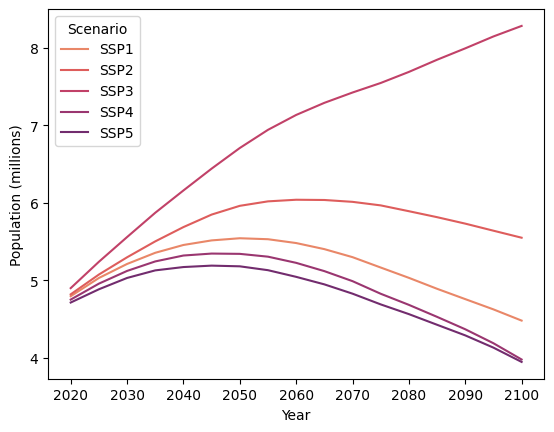

In [3]:
if __name__ ==  '__main__':
    export_popdynamics()


In [4]:
base_dir= 'C:/Users/Aziz/Dropbox/CRP/FCS' # Project directory
output_dir= f'{base_dir}/output' # csv and figure output directory
data_dir= f'{base_dir}/data'  # Input data directory
shp = f'{data_dir}/test_cities/Test_City2.shp' # City shapefile
country = 'BGD'
city= 'Chittagong'
fsc_data_sections= ['gdp']
          
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

def export_gdp():
    for subdir in fsc_data_sections:
        combined_results = []
        extension = '.tif'
        for root, dirs_list, files_list in os.walk( os.path.join(data_dir, subdir)):
            for file_name in files_list:
                if os.path.splitext(file_name)[-1] == extension:
                    file_name_path = os.path.join(root, file_name)
                    file_name = os.path.splitext(file_name)[0]
                    # print(file_name,  file_name_path, subdir)
                    Year = file_name[3:7]
                    ssp = file_name[9:14]
                    # print(file_name,  file_name_path, Year, ssp , subdir)
                    rst = file_name_path # f'{data_dir}/popdynamics/wang/SPP1/SSP1_2020.tif'
                    out_rst = f'{output_dir}/{subdir}_{file_name}.tif'
                    raster = rasterio.open(rst)
                    vector = load_shapefile(shp)
                    p_vector = reproject_gpdf(vector, raster)
                    stats_to_get = list_statistics()
                    df = calculate_zonal_stats(p_vector, rst, stats_to_get)
                    df['Scenario'] = ssp
                    df['Scenario'] = df['Scenario'].str.upper()
                    df['Year'] = Year
                    combined_results.append(df)

        # Append vertically and then pivot horizontally.
        df = gpd.GeoDataFrame( pd.concat( combined_results, ignore_index=True) )
       # Wide
        df_tranformed= df.pivot(index=['Scenario'], columns='Year', values='sum')
        # Long
        df_graph = df_tranformed.melt(ignore_index=False).reset_index()
        # export csv of wide
        df_tranformed.to_csv(f"{output_dir}/{country}_{city}_{subdir}.csv")
        #run the visualize function to export the heatmap
        visualize_gdp_figure(df_tranformed, country, city, subdir)
        visualize_gdp_graph(df_graph, country, city, subdir)



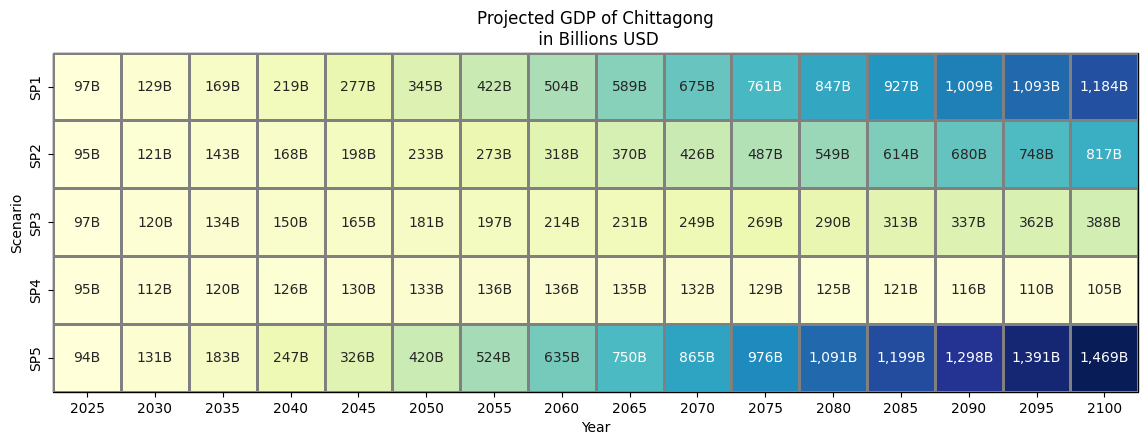

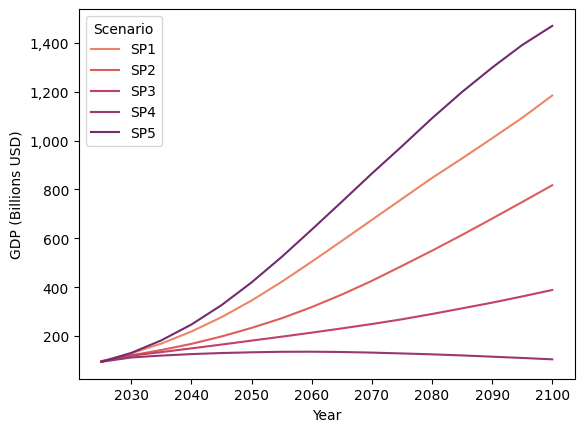

In [5]:
if __name__ ==  '__main__':
    export_gdp()

In [6]:
# heatflux


In [ ]:
# urban land